---
## Step 0: Load The Data

In [10]:
# Load pickled data
import pickle
import numpy as np

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [11]:
import pandas as pd

train_data = pd.read_csv("signnames.csv")


assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

n_train = np.shape(X_train)[0]

# Number of validation examples
n_validation = np.shape(X_valid)[0]

# Number of testing examples.
n_test = np.shape(X_test)[0]

# What's the shape of an traffic sign image?
image_shape = len(train['features'][0, 0, 0])

# How many unique classes/labels there are in the dataset.
n_classes = np.shape(train['labels'])

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape, train['features'][0, 0, 0])
print("Number of classes =", len(train_data))

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = 3 [28 25 24]
Number of classes = 43


### Include an exploratory visualization of the dataset

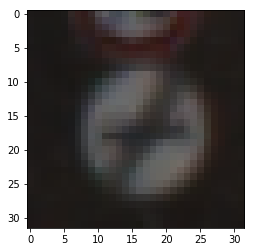

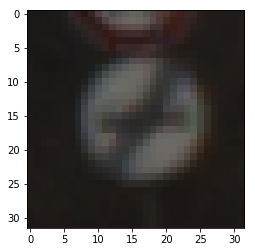

In [12]:
### Data exploration visualization

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
for i in range(2):
    plt.imshow(X_train[i])
    plt.show()

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [13]:

from tqdm import tqdm
import cv2

# converting to grayscale

def convert_to_gray(data):
    print("Converting to grayscale ..")
    result = []
    for i in tqdm(range(len(data))):
        result.append(cv2.cvtColor(data[i], cv2.COLOR_RGB2GRAY))
    return np.reshape(result,(len(data), 32, 32, 1))

# apply gaussian blur

def gaussian_blur(data):
    print("Applying Gaussian Blur ..")
    result = []
    for i in tqdm(range(len(data))):
        result.append(cv2.GaussianBlur(data[i], (5,5), 0))
        
    return result

# Apply gamma correction

In [14]:
def adjust_gamma(data, gamma=1.0):
    print("Applying Gamma correction ..")
    result = []
    for j in tqdm(range(len(data))):
        # build a lookup table mapping the pixel values [0, 255] to
        # their adjusted gamma values
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255
            for i in np.arange(0, 256)]).astype("uint8")

        # apply gamma correction using the lookup table
        result.append(cv2.LUT(data[j], table))
        table = []
    return result
'''
# test out on 5 random images
for i in range(2):
    rnd = np.random.randint(0, len(X_train))
    img = X_train[rnd]
    plt.imshow(img)
    plt.show() 
    gamma_corrected = adjust_gamma(img, 2.2)
    plt.imshow(gamma_corrected)
    plt.show()
'''

'\n# test out on 5 random images\nfor i in range(2):\n    rnd = np.random.randint(0, len(X_train))\n    img = X_train[rnd]\n    plt.imshow(img)\n    plt.show() \n    gamma_corrected = adjust_gamma(img, 2.2)\n    plt.imshow(gamma_corrected)\n    plt.show()\n'

In [15]:

# Rotate the image by an angle
#the routine below will work on grayscale images only
def rotation(data, angle):
    print("Rotating ..")
    result = []
    for i in tqdm(range(len(data))):
        img = np.reshape(data[i],(32,32,1))
        rows, cols ,channels = np.shape(img)
        rot_mat = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1.0)
        dst = cv2.warpAffine(img,rot_mat,(cols,rows))
        result.append(dst)
    return np.reshape(result, (len(result),32,32,1))


In [16]:
#image normalization by averaging

def normalize(data):
    # define local variables
    print("Normalizing ..")
    result = []
    second_axis = []
    first_axis = []
    # iterate through entire training set
    for i in tqdm(range(len(data))):
        # iterate through all rows
        for j in range(len(data[0])):
            # iterate through all columns
            for k in range(len(data[0][0])):
                # normalize 
                result.append(((data[i][j][k]/255.0) - 0.5))
            # fill up the row dimension
            second_axis.append(result) 
            #flush data
            result = []
        # fill up the training set dimension
        first_axis.append(second_axis) 
        #flush data
        second_axis = []
        
    return first_axis


## Data Preprocessing

In [17]:
# apply preprocessing to training dataset
# 1. Blur image
# 2. convert to grayscale
# 3. normalize
# 4. gamma correct

def data_preprocessing(X_data):
    X_processed = gaussian_blur(X_data)
    X_processed = convert_to_gray(X_processed)
    X_processed = adjust_gamma(X_processed, 2.2)
    X_processed = normalize(X_processed)
    
    return np.reshape(X_processed,(len(X_processed), 32, 32, 1))




## Dataset Augmentation

In [18]:

def augmented_dataset(X_data, y_data):
    # create empty arrays for augmenting dataset
    X_rotated_left = []
    y_rotated_left = []

    X_rotated_right = []
    y_rotated_right = []
    
    X_rotated_left = rotation(X_data, 10)
    y_rotated_left = y_data
    
    X_rotated_right = rotation(X_data, -10)
    y_rotated_right = y_data
    
    return (np.concatenate((X_data, X_rotated_left, X_rotated_right)),np.concatenate((y_data, y_rotated_left, y_rotated_right))) 



### Model Architecture

In [19]:
### LeNet based architecture


import tensorflow as tf
from tensorflow.contrib.layers import flatten


EPOCHS = 30
BATCH_SIZE = 128

def LeNet(x):    

    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. The output shape should be 28x28x6
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return [logits, conv1_W, conv2_W, fc1_W, fc2_W, fc3_W]
    

Features and Labels

In [20]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, len(train_data))

### Augment and preprocess the datasets

In [21]:
X_augmented, y_augmented = augmented_dataset(data_preprocessing(X_train), y_train)

X_valid = data_preprocessing(X_valid)
X_test = data_preprocessing(X_test)

 10%|█         | 3586/34799 [00:00<00:00, 35856.44it/s]

Applying Gaussian Blur ..


 34%|███▍      | 11823/34799 [00:00<00:00, 118225.60it/s]

Converting to grayscale ..


  0%|          | 98/34799 [00:00<00:35, 972.24it/s]

Applying Gamma correction ..


  0%|          | 23/34799 [00:00<02:36, 221.65it/s]

Normalizing ..


  8%|▊         | 2623/34799 [00:00<00:01, 26225.71it/s]

Rotating ..


  8%|▊         | 2718/34799 [00:00<00:01, 27174.52it/s]

Rotating ..


  0%|          | 0/4410 [00:00<?, ?it/s]

Applying Gaussian Blur ..
Converting to grayscale ..
Applying Gamma correction ..


  1%|          | 23/4410 [00:00<00:19, 225.81it/s]

Normalizing ..


 37%|███▋      | 4625/12630 [00:00<00:00, 46249.49it/s]

Applying Gaussian Blur ..


  0%|          | 0/12630 [00:00<?, ?it/s]

Converting to grayscale ..
Applying Gamma correction ..


  0%|          | 23/12630 [00:00<00:56, 225.02it/s]

Normalizing ..


100%|██████████| 12630/12630 [00:57<00:00, 220.06it/s]


### Pickle the augmented dataset

In [22]:

with open("train_augmented.p", 'wb') as f:
    pickle.dump((X_augmented, y_augmented),f)

with open("valid_processed.p", 'wb') as f:
    pickle.dump((X_valid, y_valid), f)

with open("test_processed.p", 'wb') as f:
    pickle.dump((X_test, y_test), f)

### Unpickle the augmented dataset files

In [23]:
training_file = "train_augmented.p"
validation_file= "valid_processed.p"
testing_file = "test_processed.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train[0], train[1]
X_valid, y_valid = valid[0], valid[1]
X_test, y_test = test[0], test[1]

### Train, Validate and Test the Model

In [24]:
### Training pipeline

rate = 0.001
reg_constant = 0.0005

[logits, conv1_W, conv2_W, fc1_W, fc2_W, fc3_W] = LeNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

regularizer = tf.nn.l2_loss(conv1_W) + tf.nn.l2_loss(conv2_W) + tf.nn.l2_loss(fc1_W) + tf.nn.l2_loss(fc2_W) + tf.nn.l2_loss(fc3_W)

loss_operation = tf.reduce_mean(cross_entropy + reg_constant * regularizer)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)

training_operation = optimizer.minimize(loss_operation)


In [25]:
# Accuracy calculations

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [26]:
# Shuffle training set

# Training commands

from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_augmented)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_augmented, y_augmented = shuffle(X_augmented, y_augmented)
        
        for offset in tqdm(range(0, num_examples, BATCH_SIZE)):
            end = offset + BATCH_SIZE
            batch_x, batch_y = np.reshape(X_augmented[offset:end], (len(X_augmented[offset:end]), 32, 32 ,1)), y_augmented[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    
    testing_accuracy = sess.run(accuracy_operation, feed_dict={x: X_test, y: y_test, keep_prob: 1.0})
    print("testing accuracy = {:.3f}".format(testing_accuracy))
    
    saver.save(sess, './lenet')
    print("Model saved")

Training...



100%|██████████| 816/816 [00:08<00:00, 94.63it/s] 


EPOCH 1 ...
Validation Accuracy = 0.841



100%|██████████| 816/816 [00:07<00:00, 115.42it/s]


EPOCH 2 ...
Validation Accuracy = 0.893



100%|██████████| 816/816 [00:07<00:00, 115.19it/s]


EPOCH 3 ...
Validation Accuracy = 0.911



100%|██████████| 816/816 [00:07<00:00, 115.54it/s]


EPOCH 4 ...
Validation Accuracy = 0.916



100%|██████████| 816/816 [00:07<00:00, 115.25it/s]


EPOCH 5 ...
Validation Accuracy = 0.931



100%|██████████| 816/816 [00:07<00:00, 115.69it/s]


EPOCH 6 ...
Validation Accuracy = 0.941



100%|██████████| 816/816 [00:07<00:00, 115.20it/s]


EPOCH 7 ...
Validation Accuracy = 0.940



100%|██████████| 816/816 [00:07<00:00, 113.20it/s]


EPOCH 8 ...
Validation Accuracy = 0.944



100%|██████████| 816/816 [00:07<00:00, 115.18it/s]


EPOCH 9 ...
Validation Accuracy = 0.946



100%|██████████| 816/816 [00:07<00:00, 115.31it/s]


EPOCH 10 ...
Validation Accuracy = 0.940



100%|██████████| 816/816 [00:07<00:00, 115.06it/s]


EPOCH 11 ...
Validation Accuracy = 0.943



100%|██████████| 816/816 [00:07<00:00, 113.58it/s]


EPOCH 12 ...
Validation Accuracy = 0.946



100%|██████████| 816/816 [00:07<00:00, 114.24it/s]


EPOCH 13 ...
Validation Accuracy = 0.951



100%|██████████| 816/816 [00:07<00:00, 115.33it/s]


EPOCH 14 ...
Validation Accuracy = 0.952



100%|██████████| 816/816 [00:07<00:00, 115.97it/s]


EPOCH 15 ...
Validation Accuracy = 0.946



100%|██████████| 816/816 [00:07<00:00, 114.97it/s]


EPOCH 16 ...
Validation Accuracy = 0.951



100%|██████████| 816/816 [00:07<00:00, 115.29it/s]


EPOCH 17 ...
Validation Accuracy = 0.953



100%|██████████| 816/816 [00:07<00:00, 115.48it/s]


EPOCH 18 ...
Validation Accuracy = 0.951



100%|██████████| 816/816 [00:07<00:00, 115.06it/s]


EPOCH 19 ...
Validation Accuracy = 0.952



100%|██████████| 816/816 [00:07<00:00, 115.49it/s]


EPOCH 20 ...
Validation Accuracy = 0.950



100%|██████████| 816/816 [00:07<00:00, 115.58it/s]


EPOCH 21 ...
Validation Accuracy = 0.947



100%|██████████| 816/816 [00:07<00:00, 114.88it/s]


EPOCH 22 ...
Validation Accuracy = 0.958



100%|██████████| 816/816 [00:07<00:00, 114.80it/s]


EPOCH 23 ...
Validation Accuracy = 0.951



100%|██████████| 816/816 [00:07<00:00, 115.45it/s]


EPOCH 24 ...
Validation Accuracy = 0.947



100%|██████████| 816/816 [00:07<00:00, 115.08it/s]


EPOCH 25 ...
Validation Accuracy = 0.949



100%|██████████| 816/816 [00:07<00:00, 114.76it/s]


EPOCH 26 ...
Validation Accuracy = 0.948



100%|██████████| 816/816 [00:07<00:00, 114.90it/s]


EPOCH 27 ...
Validation Accuracy = 0.956



100%|██████████| 816/816 [00:07<00:00, 111.84it/s]


EPOCH 28 ...
Validation Accuracy = 0.950



100%|██████████| 816/816 [00:07<00:00, 113.23it/s]


EPOCH 29 ...
Validation Accuracy = 0.952



100%|██████████| 816/816 [00:07<00:00, 114.07it/s]


EPOCH 30 ...
Validation Accuracy = 0.944

testing accuracy = 0.942
Model saved


### Load and Output the Test Images

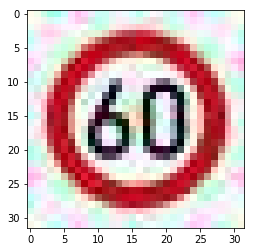

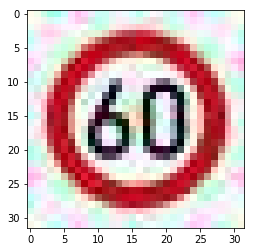

(32, 32, 3)
(32, 32, 3)
(1, 32, 32, 3)


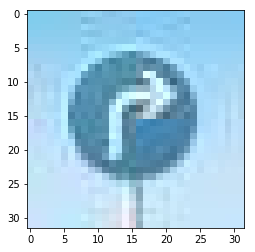

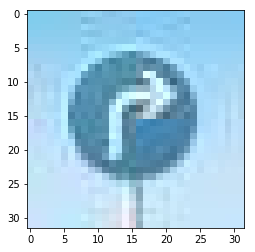

(32, 32, 3)
(32, 32, 3)
(2, 32, 32, 3)


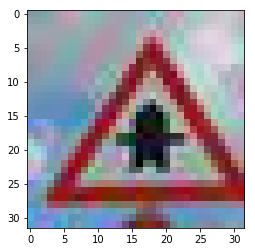

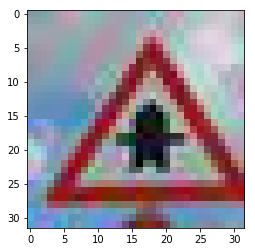

(32, 32, 3)
(32, 32, 3)
(3, 32, 32, 3)


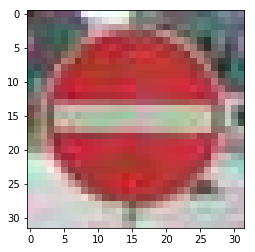

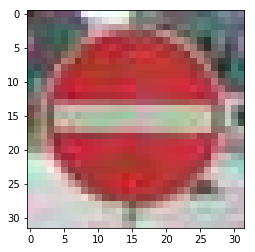

(32, 32, 3)
(32, 32, 3)
(4, 32, 32, 3)


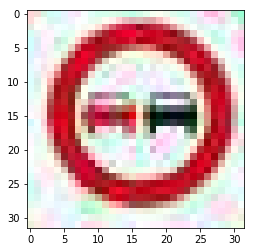

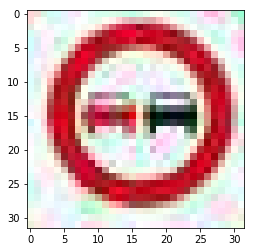

(32, 32, 3)
(32, 32, 3)
(5, 32, 32, 3)


In [45]:
### Load the images and plot them here.
import os
import matplotlib.image as mpimg
from PIL import Image
from resizeimage import resizeimage
import matplotlib.pyplot as plt
import numpy as np

test_set = []
test_images_path = "test-set/"
test_images = os.listdir(test_images_path)

i=0
for image in test_images:
    with open(test_images_path+image, 'r+b') as f:
        with Image.open(f) as test_image:
            plt.imshow(test_image)
            plt.show()
            cover = resizeimage.resize_cover(test_image, (32, 32, 3))
            plt.imshow(cover)
            plt.show()
            cover.save(test_images_path+image, test_image.format)
            print(np.shape(cover))
            test_set.append(np.copy(cover))
            print(np.shape(test_set[i]))
    i+=1
    print(np.shape(test_set))


## Preprocess new images

In [46]:
test_set = data_preprocessing(test_set)


100%|██████████| 5/5 [00:00<00:00, 219.33it/s]

Applying Gaussian Blur ..
Converting to grayscale ..
Applying Gamma correction ..
Normalizing ..


### Predict the Sign Type for Each Image

In [47]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess,'./lenet')
    predicted_logits=sess.run(logits,feed_dict={x:test_set, keep_prob: 1})
    #sess.run(LeNet,feed_dict={x:test_images})
    #print(predicted_logits)
    predicted_prob=sess.run(tf.nn.softmax(predicted_logits))
    predicted_labels = np.argmax(predicted_logits, axis=1)
    print(predicted_labels)

[ 3 33 11 17  9]


### Analyze Performance

In [37]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [38]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [39]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")